In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Path to your Excel file
file_path = './UPDATED_NM student infractions 2010-2022.xlsx'

# Read the Excel file
df = pd.read_excel(file_path)

# Display the DataFrame
print(df)

KeyboardInterrupt: 

In [60]:
column_names = df.columns
print(column_names)
print(len(df))
group_lengths_list = df.groupby('District Name').size().tolist()
print(group_lengths_list)

Index(['District Name', 'District Code', 'Location Organization Type Code',
       'School Year', 'Student Grade Level', 'Infraction Event ID',
       'Discipline Infraction Date', 'Discipline Infraction Code',
       'Discipline Infraction', 'Drug Related', 'Alcohol Related',
       'Gang Related', 'Hate Crime', 'Serious Injury', 'Criminal Charge Code',
       'Repeat Offender', 'Discipline Response Code', 'Discipline Response',
       'Discipline Response Duration', 'Admin First Name', 'Admin Last Name',
       'Admin License Number', 'Student Gender Code',
       'Student Race Ethnicity Derived', 'Student Hispanic Indicator',
       'Special Ed Status Code', 'Gifted Participation Code', 'Immigrant',
       'Food Program Participation Code', 'Section 504 Status', 'R3', 'W1',
       'W2', 'W4', 'W5', 'WD', 'WDO', 'WG', 'WC', 'Race Initials'],
      dtype='object')
285917
[289, 9, 240, 48, 3751, 88971, 11, 3, 161, 60, 5, 133, 8, 10, 472, 4124, 4463, 2793, 1527, 294, 4621, 196, 5114, 17

*PRIVACY MECHANISM*
Noising Entire Dataset (but assuming we are noising batches of data per year)
Varying Epsilon value per school, smaller school gets smaller epsilon (how? TODO)

In [51]:
import random
import math

def get_flip_probability(k, epsilon):
    """
    Compute flip probability based K-ary Randomized Response equation
    Probability to flip to value
    PRflip = 1 - e^epsilon / (e^epsilon + k - 1)
    Args:
        k: number of values (alphabets/categories) in the distribution (column)
        epsilon: the privacy budget
    Returns:
        PRflip: the probability to flip x value
    """
    PRflip = 1 - math.e**epsilon / (math.e**epsilon + k - 1)
    return PRflip

def flip_value(x, X, epsilon):
    """
    Randomly flips the value of 'x' using K-ary randomized response mechanism,
    by randomly selecting other value 'y' to replace 'x' selected from 'X'
    Args:
        x: The input value to potentially flip.
        X: A list of other possible values to choose from.
        epsilon: the privacy budget
    Returns:
        y: The flipped or unchanged value of 'x'.
    """
    # Generate a random number between 0 and 1
    random_number = random.random()
    # Generate probability to flip x
    k = len(X) # number of values (alphabets/categories) in the domain
    flip_probability = get_flip_probability(k, epsilon)
    # get_selection_probability(k, epsilon) # we don't need it?
    # Check if we should flip the value
    if random_number <= flip_probability:
        # Flip the value by selecting a random value from known_values other than 'x'
        y = random.choice([value for value in X if value != x])
        return y
    else:
        # Keep the value x
        return x

def noise_column(c_sr, X, epsilon):
    """
    Apply to entire column
    Parameters:
    - c_sr: Pandas Series containing values from column of interest
    - X: possible values in column
    - epsilon: Privacy budget for differential privacy. Lower values mean more privacy.
    Return:
    - c_private: List of privatized column
    """
    # apply DP to list of c_sr
    c_private = map(lambda x: flip_value(x, X, epsilon), c_sr.tolist())
    c_private= list(c_private)
    return c_private

def get_epsilon(size, epsilon_config): # CHANGE for MULTIPLE EPSILON VALUES
    """
    Get epsilon value depending on number of entries in group/school. e = 3 for more than 1000, e = 2 for more than 100 and less than 1000, and e =1  for less than 100    
    Parameters:
    - size: Number of entries
    Return:
    - epsilon: value
    """
    # TODO read and change based on epsilon_config
    return 3 if size > 1000 else 2 if size > 100 else 1

def generate_possible_values(df, columns_to_noise):
    """
    Creates a python Dictionary of column names and Lists of their respective values from entire dataset. Only for columns that need to be noised   
    Parameters:
    - df: DataFrame containing the school data.
    - columns_to_noise: List of columns headers that need to be noised
    Return:
    - Python Dictionary of column names and Lists of their respective values
    """
    possible_values = {}
    # Iterate over columns
    for column in columns_to_noise:
        # Get unique values for the column
        possible_values[column] = df[column].unique().tolist()
    return possible_values

def noise_dataframe(df, columns_to_noise, epsilon_config):
    """
    Apply noising for entire dataset by noising every school district with adapted epsilon value. Columns are noised independently.    
    Parameters:
    - df: DataFrame containing the school data.
    - columns_to_noise: List of columns headers that need to be noised
    """
    df_noised = pd.DataFrame(columns=df.columns) # empty placeholder
    # generate possible values per column of interest
    values_per_column = generate_possible_values(df, columns_to_noise)
    # get names of schools/school districts
    school_names = df['District Name'].unique().tolist()
    # noising every school
    for school in school_names:
        print("*~*~*~*~*Running School: ", school," *~*~*~*~*")
        school_df = df[df['District Name'] == school].copy()
        # get adaptive epsilon value
        school_case_numbers = len(school_df)
        curr_epsilon = get_epsilon(school_case_numbers, epsilon_config) 
        for column in columns_to_noise:
            # get unique values of column
            X = values_per_column[column]
            # noise column
            noised_column = noise_column(school_df[column], X, curr_epsilon)
            school_df[column] = noised_column
        # append noised school dataframe to main noised dataframe
        df_noised = pd.concat([df_noised, school_df], ignore_index=True)
    return df_noised

In [52]:
# TEST RUN NOISING
columns_to_noise = ["Discipline Infraction","Student Race Ethnicity Derived","Drug Related","Alcohol Related","Gang Related","Hate Crime","Serious Injury","Criminal Charge Code","Repeat Offender","Immigrant","Gifted Participation Code","Student Grade Level","Student Gender Code"
]
epsilon_config = [2] # does nothing for now
noised_df = noise_dataframe(df, columns_to_noise, epsilon_config)

*~*~*~*~*Running School:  ABQ SCHOOL OF EXCELLENCE  *~*~*~*~*
*~*~*~*~*Running School:  ABQ SIGN LANGUAGE ACADEMY  *~*~*~*~*
*~*~*~*~*Running School:  ACADEMY OF TRADES AND TECH  *~*~*~*~*
*~*~*~*~*Running School:  ACE LEADERSHIP HIGH SCHOOL  *~*~*~*~*
*~*~*~*~*Running School: 

C:\Users\artem\AppData\Local\Temp\ipykernel_31108\1780977258.py:112: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_noised = pd.concat([df_noised, school_df], ignore_index=True)


 ALAMOGORDO  *~*~*~*~*
*~*~*~*~*Running School:  ALBUQUERQUE  *~*~*~*~*
*~*~*~*~*Running School:  ALBUQUERQUE BILINGUAL ACADEMY  *~*~*~*~*


C:\Users\artem\AppData\Local\Temp\ipykernel_31108\1780977258.py:112: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_noised = pd.concat([df_noised, school_df], ignore_index=True)


*~*~*~*~*Running School:  ALBUQUERQUE COLLEGIATE CHARTER SCHOOL  *~*~*~*~*
*~*~*~*~*Running School:  ALDO LEOPOLD CHARTER  *~*~*~*~*
*~*~*~*~*Running School:  ALMA D'ARTE CHARTER  *~*~*~*~*
*~*~*~*~*Running School:  ALTURA PREPARATORY SCHOOL  *~*~*~*~*
*~*~*~*~*Running School:  AMY BIEHL CHARTER HIGH SCHOOL  *~*~*~*~*
*~*~*~*~*Running School:  ANIMAS  *~*~*~*~*
*~*~*~*~*Running School:  ANTHONY CHARTER SCHOOL  *~*~*~*~*
*~*~*~*~*Running School:  ARTESIA  *~*~*~*~*
*~*~*~*~*Running School:  AZTEC  *~*~*~*~*
*~*~*~*~*Running School:  BELEN  *~*~*~*~*
*~*~*~*~*Running School:  BERNALILLO  *~*~*~*~*
*~*~*~*~*Running School:  BLOOMFIELD  *~*~*~*~*
*~*~*~*~*Running School:  CAPITAN  *~*~*~*~*
*~*~*~*~*Running School:  CARLSBAD  *~*~*~*~*
*~*~*~*~*Running School:  CARRIZOZO  *~*~*~*~*
*~*~*~*~*Running School:  CENTRAL CONS.  *~*~*~*~*
*~*~*~*~*Running School:  CENTRAL CONSOLIDATED  *~*~*~*~*
*~*~*~*~*Running School:  CESAR CHAVEZ COMMUNITY  CENTER  *~*~*~*~*
*~*~*~*~*Running School:  CESAR CH

In [53]:
print(test_df)
print(len(df), len(noised_df))

None
285917 285917


======================RAW DF======================
REPEATED COUNTS===============================


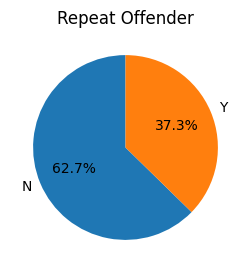

Grade COUNTS==================================
PK      862
KF     4749
1      6359
2      6732
3      7849
4      9322
5     11651
6     35301
7     44601
8     45976
9     46487
10    33491
11    20416
12    12111
OS       10
Name: count, dtype: int64
INFRACTIONS COUNTS==================================
Discipline Infraction
Disorderly Conduct                                                                     86323
Assault/battery with hands/feet/fist                                                   50429
Drug Violation                                                                         36125
Assault/battery simple                                                                 35213
Tobacco Use                                                                            13339
Other Violence - General                                                               11178
Bullying                                                                                7391
Missing Property/Thef

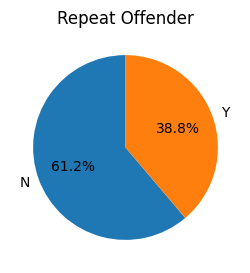

Grade COUNTS==================================
PK     9395
KF    11386
1     12067
2     12433
3     12916
4     13602
5     14941
6     28037
7     33187
8     33480
9     33797
10    26866
11    19784
12    15274
OS     8752
Name: count, dtype: int64
INFRACTIONS COUNTS==================================
Discipline Infraction
Disorderly Conduct                                                                     33532
Assault/battery with hands/feet/fist                                                   22059
Drug Violation                                                                         16957
Assault/battery simple                                                                 16781
Tobacco Use                                                                             9496
Other Violence - General                                                                8708
Bullying                                                                                7626
Missing Property/Thef

In [56]:
import matplotlib.pyplot as plt
def viz_testdf(df):
    # running some queries to quick hand test raw and noised df difference
    print("REPEATED COUNTS===============================")
    repeat_counts = df['Repeat Offender'].value_counts()
    repeat_counts.plot(kind='pie', figsize=(3, 3), autopct='%1.1f%%', startangle=90)
    plt.title('Repeat Offender')
    plt.ylabel('')  # Hide the y-label
    plt.show()
    print("Grade COUNTS==================================")
    # Assuming df['Student Grade Level'] contains the grade levels as shown previously
    grade_counts = df['Student Grade Level'].value_counts()
    # Define the correct order for the grade levels
    grade_order = ['PK', 'KF', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', 'OS']
    # Convert the grade levels in the index to a Categorical type with the defined order
    grade_counts.index = pd.Categorical(grade_counts.index, categories=grade_order, ordered=True)
    # Sort the Series by its index
    sorted_grade_counts = grade_counts.sort_index()
    print(sorted_grade_counts)
    print("INFRACTIONS COUNTS==================================")
    Discipline_Infraction_counts = df['Discipline Infraction'].value_counts()
    print(Discipline_Infraction_counts)

print("======================RAW DF======================")
viz_testdf(df)
print("======================NOISED DF======================")
viz_testdf(noised_df)